# Training and testing with Kloten features
- Random tuning
- Testing with tuned and default XgBoostClassifier
## Targets
- manual_bise
- rule-4-duration


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
# Python libs
import numpy as np
import pandas as pd
from os.path import isfile, join
import os.path
import re
from google.colab import drive
import sys
import datetime as datetime
import xgboost as xgb
import pickle

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score, precision_score, f1_score
import time
import datetime as dt

import seaborn as sn
import matplotlib.pyplot as plt

<h3>Colab is problematic when importing scripts, especially if modifications are made. This is due to its caching of resources so no scripts are imported. The required functionality from the scripts are reproduced in one unique cell, in order to faclitate reproduction in other notebooks</h3>

In [0]:
steps_10_mins = 1
steps_20_mins = 2
steps_30_mins = 3
steps_1_hour = 6
steps_2_hours = 12
steps_12_hours = 12 * steps_1_hour
steps_24_hours = 24 * steps_1_hour

column_year = 'year'
column_month = 'month'
column_hour = 'hour'

MASTER_DATASET = 'model_data_all_features_extended.csv.zip'

In [0]:
def run_xgboost_predictions_no_tuning(df_train_x, df_train_y, df_test_x, df_test_y, longest_pred_period, dump_dir=None,
                                      **hyperparams):
    """Runs XGBoost with a fixed set of classifier hyperparameters, perfoming data delay to a maximum of 'longest_pred_period'
    steps (corresponding to 10 mins each)"""
    # initialise two empty dictionaries to store the models and scores
    xgboostmodels = {}
    xgboostscores = {}
    xgboostconfmatrixes = {}
    xgboostpredictions = {}
    prediction_period = [i for i in
                         range(1, longest_pred_period + 1)]  # how far into the future to predict (10 minute segments)

    score = -1
    counter = 1
    for prediction in prediction_period:

        reg = xgb.XGBClassifier()
        reg.set_params(**hyperparams)
        X_train = df_train_x[:-prediction]  # everything except the last value
        y_train = df_train_y[prediction:]  # offset by 10mins

        X_test = df_test_x[:-prediction]  # everything except the last value
        y_test = df_test_y[prediction:]  # offset by 10mins

        key = 'xgboost_model_' + str(prediction * 10)

        xgboostmodels[key] = reg.fit(X_train, y_train, verbose=2)  # store the model

        # score = np.mean(ms.cross_val_score(reg, x_train, y_train, scoring='roc_auc', cv=5))

        y_pred = reg.predict(X_test)
        xgboostpredictions[key] = y_pred

        prec_score, rec_score, f_score = get_scores(y_test, y_pred)
        xgboostscores[key] = rec_score  # store the model score

        print(classification_report(y_test, y_pred))
        print(counter, rec_score)
        if rec_score > score:
            if dump_dir:
                file_path = join(dump_dir, 'xgb_no_tuning_' + str(time.time()) + '.dat')
                print(f'Model improved accuracy, saving to {file_path}')
                pickle.dump(reg, open(file_path, "wb"))
            score = rec_score
        counter += 1

        cm = None
        try:
            cm = confusion_matrix(y_test, y_pred)
        except:
            print('Confusion Matrix crash!!!')
            print(type(y_test), type(y_pred))

        xgboostconfmatrixes[key] = cm
    return xgboostmodels, xgboostscores, xgboostconfmatrixes, xgboostpredictions


def get_scores(y_test, y_pred):
    prec_score = precision_score(y_test.values, y_pred, average=None)
    #print('precision score: {:.6f}'.format(prec_score))

    rec_score = recall_score(y_test.values, y_pred, average=None)
    #print('recall score: {:.6f}'.format(rec_score))
    f_score = f1_score(y_test.values, y_pred, average=None)
    #print('f1 score: {:.6f}'.format(f_score))

    return prec_score, rec_score, f_score
  

def train_test_modeling_multiclass(df_train, df_test, features, predicted_value):
    prediction = 2

    # Create the train test data sets
    X_train = df_train[features][:-prediction]  # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:]  # offset by 20mins
    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:]  # offset by 20mins

    parameters = {"scale_pos_weight": range(0, 5),
                  "n_estimators": range(10, 200, 10),
                  "learning_rate": [0.05, 0.1],
                  "max_depth": range(1, 10),
                  "subsample": [0.4, 0.7, 0.9],
                  "colsample_bytree": [0.3, 0.5, 1],
                  "gamma": [0, 1, 5],
                  }
    scoring = {'f1': make_scorer(f1_score, average='weighted')}

    XGB = xgb.XGBClassifier(objective="multi:softprob", num_class=4)
    XGB_base_rand = RandomizedSearchCV(XGB, parameters, cv=3, scoring=scoring, return_train_score=True, n_jobs=-1,
                                       refit='f1')
    XGB_base_rand.fit(X_train, y_train)
    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))


def train_test_modeling(df_train, df_test, features, predicted_value):
    prediction = 2

    # Create the train test data sets
    X_train = df_train[features][:-prediction]  # everything except the 2 last values
    y_train = df_train[predicted_value][prediction:]  # offset by 20mins
    X_test = df_test[features][:-prediction]  # everything except the 2 last values
    y_test = df_test[predicted_value][prediction:]  # offset by 20mins

    parameters = {"scale_pos_weight": range(0, 5),
                  "n_estimators": range(10, 200, 10),
                  "learning_rate": [0.02, 0.05, 0.1],
                  "max_depth": range(1, 10),
                  "subsample": [0.4, 0.7, 0.9],
                  "colsample_bytree": [0.3, 0.5, 1],
                  "gamma": [0, 1, 5],
                  }

    XGB = xgb.XGBClassifier(objective='binary:logistic')
    XGB_base_rand = RandomizedSearchCV(XGB, parameters, cv=3, scoring="f1", return_train_score=True, n_jobs=-1)
    XGB_base_rand.fit(X_train, y_train)
    print(XGB_base_rand.best_params_)
    print(XGB_base_rand.best_score_)
    print('Test score: {}'.format(XGB_base_rand.score(X_test, y_test)))
    
    return XGB_base_rand
  
def timer(start_time=None):
    if not start_time:
        start_time = dt.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((dt.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))
        
        
def left_join_datasets(left, right, on='datetime'):
    """
    Performs left join (merge) upon column 'on'.
    At least one of the dataframes should carry the 'on' column
    :param left: dataframe
    :param right: dataframe
    :param on: column upon which the dataframes are merged
    :return: new dataframe
    """
    
    drop_on_from_left = False
    drop_on_from_right = False


    if not(on in left.columns):
        if not(on in right.columns):
            raise Exception('Specified column to join on in neither dataset')
        else:
            left.insert(0, on, right[on])
            drop_on_from_left = True

    if not (on in right.columns):
        right.insert(0, on, left[on])
        drop_on_from_right = True

    df = pd.merge(left, right, on=on)

    if drop_on_from_left:
        left.drop(columns=[on], inplace=True)
    elif drop_on_from_right:
        right.drop(columns=[on], inplace=True)

    return df
  
def extract_year_as_column(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_year] = pd.DatetimeIndex(df[datetime_col]).year
    
def extract_month_as_column(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_month] = pd.DatetimeIndex(df[datetime_col]).month
    
def extract_hour_as_column(df, datetime_col='datetime'):

    if not (datetime_col in df.columns):
        raise Exception('Datetime column expected')

    df[column_hour] = pd.DatetimeIndex(df[datetime_col]).hour


def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sn.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig


def run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, pred_period=None, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification"""

    reg = xgb.XGBClassifier()
    reg.set_params(**hyperparams)
    
    X_train = df_train_x[:-pred_period]
    y_train = df_train_y[pred_period:]

    X_test = df_test_x[:-pred_period]
    y_test = df_test_y[pred_period:]

    reg.fit(X_train, y_train, verbose=2)

    y_pred = reg.predict(X_test)

    prec_score, rec_score, f_score = get_scores(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    if dump_dir:
        file_path = join(dump_dir, 'xgb_no_tuning_single_pred' + str(time.time()) + '.dat')
        print(f'saving to {file_path}')
        pickle.dump(reg, open(file_path, "wb"))

    cm = None

    try:
        cm = confusion_matrix(y_test, y_pred), y_pred
    except:
        print('Confusion Matrix crash!!!')
        print(type(y_test), type(y_pred))


    return reg, prec_score, rec_score, f_score, cm
  

def run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, dump_dir=None, **hyperparams):
    """Runs a single xgboost classification"""

    reg = xgb.XGBClassifier()
    reg.set_params(**hyperparams)
    
    X_train = df_train_x
    y_train = df_train_y
    
    X_test = df_test_x
    y_test = df_test_y

    reg.fit(X_train, y_train, verbose=2)

    y_pred = reg.predict(X_test)

    prec_score, rec_score, f_score = get_scores(y_test, y_pred)

    print(classification_report(y_test, y_pred))

    if dump_dir:
        file_path = join(dump_dir, 'xgb_no_tuning_single_pred' + str(time.time()) + '.dat')
        print(f'saving to {file_path}')
        pickle.dump(reg, open(file_path, "wb"))

    cm = None

    try:
        cm = confusion_matrix(y_test, y_pred), y_pred
    except:
        print('Confusion Matrix crash!!!')
        print(type(y_test), type(y_pred))


    return reg, prec_score, rec_score, f_score, cm


 

In [0]:
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
pd.set_option('display.max_columns', None)

In [4]:
drive.mount('/gdrive')
#drive.mount('/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
model_path = '../gdrive/My Drive/Colab Notebooks/serializations'

In [0]:
data_path = '../gdrive/My Drive/bise_data'

In [7]:
file_master = os.path.join(data_path, MASTER_DATASET)
df_master = pd.read_csv(file_master, index_col=0)
df_master.head()

,datetime,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_dir_spread30,BIZ_Wind_dir_spread60,BIZ_Wind_max_EW,BIZ_Wind_max_NS,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed_EW,BIZ_Wind_speed_NS,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_dir_spread30,BUS_Wind_dir_spread60,BUS_Wind_max_EW,BUS_Wind_max_NS,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed_EW,BUS_Wind_speed_NS,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_dir_spread30,GUT_Wind_dir_spread60,GUT_Wind_max_EW,GUT_Wind_max_NS,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed_EW,GUT_Wind_speed_NS,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_dir_spread30,KOP_Wind_dir_spread60,KOP_Wind_max_EW,KOP_Wind_max_NS,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed_EW,KOP_Wind_speed_NS,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_dir_spread30,MOA_Wind_dir_spread60,MOA_Wind_max_EW,MOA_Wind_max_NS,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed_EW,MOA_Wind_speed_NS,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_dir_spread30,MUB_Wind_dir_spread60,MUB_Wind_max_EW,MUB_Wind_max_NS,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed_EW,MUB_Wind_speed_NS,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_dir_spread30,PAY_Wind_dir_spread60,PAY_Wind_max_EW,PAY_Wind_max_NS,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed_EW,PAY_Wind_speed_NS,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_dir_spread30,PUY_Wind_dir_spread60,PUY_Wind_max_EW,PUY_Wind_max_NS,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed_EW,PUY_Wind_speed_NS,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_dir_spread30,REH_Wind_dir_spread60,REH_Wind_max_EW,REH_Wind_max_NS,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed_EW,REH_Wind_speed_NS,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_dir_spread30,SHA_Wind_dir_spread60,SHA_Wind_max_EW,SHA_Wind_max_NS,SHA_Wind_max,SHA_Wind_max_delta_3,SHA_Wind_max_delta_6,SHA_Wind_speed_EW,SHA_Wind_speed_NS,SHA_Wind_speed,SHA_Wind_speed_delta_3,SHA_Wind_speed_delta

In [0]:
file_length_class = os.path.join(data_path, 'length_classes_manual_rule4.csv')
df_lenght_class = pd.read_csv(file_length_class, index_col=0)
df_lenght_class.sample(10)

,manual_bise,manual_duration_class,rule4_episode_1_0,rule4_duration_class
39684,1,1,0,0
131291,0,0,0,0
168180,0,0,0,0
20627,0,0,0,0
224365,0,0,0,0
238948,0,0,0,0
51464,0,0,0,0
116867,1,2,1,3
129480,0,0,0,0
213190,0,0,0,0


In [8]:
file_class = os.path.join(data_path, 'bise_classifications_extended.csv.zip')
df_lenght_class = pd.read_csv(file_class, index_col=0)
df_lenght_class.sample(10)

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class
29489,2014-07-24 18:50:00,29489,2014,7,0,0,0,0.000,0.000,0,0,0,0,0,0,0
245992,2018-09-05 06:40:00,245992,2018,9,0,0,0,0.000,0.000,0,0,0,0,0,0,0
94642,2015-10-20 05:40:00,94642,2015,10,0,0,0,0.000,0.000,0,0,0,0,0,0,0
30558,2014-08-01 05:00:00,30558,2014,8,0,0,0,0.000,0.000,0,0,0,0,0,0,0
57767,2015-02-06 03:50:00,57767,2015,2,1,0,0,0.000,0.000,0,0,1,1,3,0,0
248958,2018-09-25 21:00:00,248958,2018,9,1,1,1,840.000,840.000,388,341,1,1,2,1,3
226625,2018-04-23 18:50:00,226625,2018,4,0,0,0,0.000,0.000,0,0,0,0,0,0,0
242054,2018-08-08 22:20:00,242054,2018,8,0,0,0,0.000,0.000,0,0,0,0,0,0,0
102893,2015-12-16 12:50:00,102893,2015,12,0,0,0,0.000,0.000,0,0,0,0,0,0,0
142200,2016-09-14 12:00:00,142200,2016,9,0,0,0,0.000,0.000,0,0,0,0,0,0,0


<h3>Merge and save classification and feature set</h3>

In [11]:
df_merged = left_join_datasets(df_lenght_class, df_master)
df_merged.shape

(262801, 832)

In [0]:
df_merged.to_csv(os.path.join(data_path, 'model_data_all_features_classified.csv.zip'), compression='zip')

In [14]:
df_merged = pd.read_csv(os.path.join(data_path, 'model_data_all_features_classified.csv.zip'), index_col=0)
df_merged.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_dir_spread30,KLO_Wind_dir_spread60,KLO_Wind_max_EW,KLO_Wind_max_NS,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed_EW,KLO_Wind_speed_NS,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_dir_spread30,BIZ_Wind_dir_spread60,BIZ_Wind_max_EW,BIZ_Wind_max_NS,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed_EW,BIZ_Wind_speed_NS,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_dir_spread30,BUS_Wind_dir_spread60,BUS_Wind_max_EW,BUS_Wind_max_NS,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed_EW,BUS_Wind_speed_NS,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_dir_spread30,GUT_Wind_dir_spread60,GUT_Wind_max_EW,GUT_Wind_max_NS,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed_EW,GUT_Wind_speed_NS,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_dir_spread30,KOP_Wind_dir_spread60,KOP_Wind_max_EW,KOP_Wind_max_NS,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed_EW,KOP_Wind_speed_NS,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_dir_spread30,MOA_Wind_dir_spread60,MOA_Wind_max_EW,MOA_Wind_max_NS,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed_EW,MOA_Wind_speed_NS,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_dir_spread30,MUB_Wind_dir_spread60,MUB_Wind_max_EW,MUB_Wind_max_NS,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed_EW,MUB_Wind_speed_NS,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_dir_spread30,PAY_Wind_dir_spread60,PAY_Wind_max_EW,PAY_Wind_max_NS,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed_EW,PAY_Wind_speed_NS,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_dir_spread30,PUY_Wind_dir_spread60,PUY_Wind_max_EW,PUY_Wind_max_NS,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed_EW,PUY_Wind_speed_NS,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_dir_spread30,REH_Wind_dir_spread60,REH_Wind_max_EW,REH_Wind_max_NS,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed_EW,REH_Wind_speed_NS,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_dir_spre

<h2>Define basic test and training sets for modelling</h2>

In [0]:
#extract_year_as_column(df_merged)

In [0]:
extract_hour_as_column(df_merged)

In [0]:
#extract_month_as_column(df_merged)

In [0]:
df_base_train = df_merged[df_merged.year < 2018]
df_base_test = df_merged[df_merged.year >= 2018]

In [0]:
print(df_base_train.shape, df_base_test.shape)

(210384, 529) (52417, 529)


In [0]:
df_base_train.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QFE,KLO_QFF,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QFE,BIZ_QFF,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QFE,BUS_QFF,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QFE,GUT_QFF,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QFE,KOP_QFF,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QFE,MOA_QFF,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QFE,MUB_QFF,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QFE,PAY_QFF,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QFE,PUY_QFF,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QFE,REH_QFF,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QFE,SHA_QFF,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_max,SHA_Wind_max_delta_3,SHA_Wind_max_delta_6,SHA_Wind_speed,SHA_Wind_speed_delta_3,SHA_Wind_speed_delta_6,SMA_Air_temp,SMA_Hum,SMA_Hum_delta_3,SMA_Hum_delta_6,SMA_QFE,SMA_QFF,SMA_QNH,SMA_Wind_dir,SMA_Wind_dir_delta,SMA_Wind_dir_delta-3,SMA_Wind_dir_delta-6,SMA_Wind_max,SMA_Wind_max_delta_3,SMA_Wind_max_delta_6,SMA_Wind_speed,SMA_Wind_speed_delta_3,SMA_Wind_speed_delta_6,TAE_Air_temp,TAE_Hum,TAE_Hum_delta_3,TAE_Hum_delta_6,TAE_QFE,TAE_QFF,TAE_QNH,TAE_Wind_dir,TAE_Wind_dir_delta,TAE_Wind_dir_delta-3,TAE_Wind_dir_delta-6,TAE_Wind_max,TAE_Wind_max_delta_3,TAE_Wind_max_delta_6,TAE_Wind_speed,TAE_Wind_speed_delta_3,TAE_Wind_speed_delta_6,VAD_Air_temp,VAD_Hum,VAD_Hum_delta_3,VAD_Hum_delta_6,VAD_QFE,VAD_QFF,VAD_QNH,VAD_Wind_dir,VAD_Wind_dir_delta,VAD_Wind_dir_delta-3,VAD_Wind_dir_delta-6,VAD_Wind_max,VAD_Wind_max_delta_3,VAD_Wind_max_delta_6,VAD_Wind_speed,VAD_Wind_speed_delta_3,VAD_Wind_speed_delta_6,WAE_Air_temp,WAE_Hum,WAE_Hum_delta_3,WAE_Hum

In [0]:
df_base_test.head()

,datetime,original_index,year,month,bise_event,rule3_episode,rule4_episode,rule3_duration,rule4_duration,rule3_label,rule4_label,manual_bise_x,manual_bise_y,manual_duration_class,rule4_episode_1_0,rule4_duration_class,KLO_Air_temp,KLO_Hum,KLO_Hum_delta_3,KLO_Hum_delta_6,KLO_QFE,KLO_QFF,KLO_QNH,KLO_Wind_dir,KLO_Wind_dir_delta,KLO_Wind_dir_delta-3,KLO_Wind_dir_delta-6,KLO_Wind_max,KLO_Wind_max_delta_3,KLO_Wind_max_delta_6,KLO_Wind_speed,KLO_Wind_speed_delta_3,KLO_Wind_speed_delta_6,BIZ_Air_temp,BIZ_Hum,BIZ_Hum_delta_3,BIZ_Hum_delta_6,BIZ_QFE,BIZ_QFF,BIZ_QNH,BIZ_Wind_dir,BIZ_Wind_dir_delta,BIZ_Wind_dir_delta-3,BIZ_Wind_dir_delta-6,BIZ_Wind_max,BIZ_Wind_max_delta_3,BIZ_Wind_max_delta_6,BIZ_Wind_speed,BIZ_Wind_speed_delta_3,BIZ_Wind_speed_delta_6,BUS_Air_temp,BUS_Hum,BUS_Hum_delta_3,BUS_Hum_delta_6,BUS_QFE,BUS_QFF,BUS_QNH,BUS_Wind_dir,BUS_Wind_dir_delta,BUS_Wind_dir_delta-3,BUS_Wind_dir_delta-6,BUS_Wind_max,BUS_Wind_max_delta_3,BUS_Wind_max_delta_6,BUS_Wind_speed,BUS_Wind_speed_delta_3,BUS_Wind_speed_delta_6,GUT_Air_temp,GUT_Hum,GUT_Hum_delta_3,GUT_Hum_delta_6,GUT_QFE,GUT_QFF,GUT_QNH,GUT_Wind_dir,GUT_Wind_dir_delta,GUT_Wind_dir_delta-3,GUT_Wind_dir_delta-6,GUT_Wind_max,GUT_Wind_max_delta_3,GUT_Wind_max_delta_6,GUT_Wind_speed,GUT_Wind_speed_delta_3,GUT_Wind_speed_delta_6,KOP_Air_temp,KOP_Hum,KOP_Hum_delta_3,KOP_Hum_delta_6,KOP_QFE,KOP_QFF,KOP_QNH,KOP_Wind_dir,KOP_Wind_dir_delta,KOP_Wind_dir_delta-3,KOP_Wind_dir_delta-6,KOP_Wind_max,KOP_Wind_max_delta_3,KOP_Wind_max_delta_6,KOP_Wind_speed,KOP_Wind_speed_delta_3,KOP_Wind_speed_delta_6,MOA_Air_temp,MOA_Hum,MOA_Hum_delta_3,MOA_Hum_delta_6,MOA_QFE,MOA_QFF,MOA_QNH,MOA_Wind_dir,MOA_Wind_dir_delta,MOA_Wind_dir_delta-3,MOA_Wind_dir_delta-6,MOA_Wind_max,MOA_Wind_max_delta_3,MOA_Wind_max_delta_6,MOA_Wind_speed,MOA_Wind_speed_delta_3,MOA_Wind_speed_delta_6,MUB_Air_temp,MUB_Hum,MUB_Hum_delta_3,MUB_Hum_delta_6,MUB_QFE,MUB_QFF,MUB_QNH,MUB_Wind_dir,MUB_Wind_dir_delta,MUB_Wind_dir_delta-3,MUB_Wind_dir_delta-6,MUB_Wind_max,MUB_Wind_max_delta_3,MUB_Wind_max_delta_6,MUB_Wind_speed,MUB_Wind_speed_delta_3,MUB_Wind_speed_delta_6,PAY_Air_temp,PAY_Hum,PAY_Hum_delta_3,PAY_Hum_delta_6,PAY_QFE,PAY_QFF,PAY_QNH,PAY_Wind_dir,PAY_Wind_dir_delta,PAY_Wind_dir_delta-3,PAY_Wind_dir_delta-6,PAY_Wind_max,PAY_Wind_max_delta_3,PAY_Wind_max_delta_6,PAY_Wind_speed,PAY_Wind_speed_delta_3,PAY_Wind_speed_delta_6,PUY_Air_temp,PUY_Hum,PUY_Hum_delta_3,PUY_Hum_delta_6,PUY_QFE,PUY_QFF,PUY_QNH,PUY_Wind_dir,PUY_Wind_dir_delta,PUY_Wind_dir_delta-3,PUY_Wind_dir_delta-6,PUY_Wind_max,PUY_Wind_max_delta_3,PUY_Wind_max_delta_6,PUY_Wind_speed,PUY_Wind_speed_delta_3,PUY_Wind_speed_delta_6,REH_Air_temp,REH_Hum,REH_Hum_delta_3,REH_Hum_delta_6,REH_QFE,REH_QFF,REH_QNH,REH_Wind_dir,REH_Wind_dir_delta,REH_Wind_dir_delta-3,REH_Wind_dir_delta-6,REH_Wind_max,REH_Wind_max_delta_3,REH_Wind_max_delta_6,REH_Wind_speed,REH_Wind_speed_delta_3,REH_Wind_speed_delta_6,SHA_Air_temp,SHA_Hum,SHA_Hum_delta_3,SHA_Hum_delta_6,SHA_QFE,SHA_QFF,SHA_QNH,SHA_Wind_dir,SHA_Wind_dir_delta,SHA_Wind_dir_delta-3,SHA_Wind_dir_delta-6,SHA_Wind_max,SHA_Wind_max_delta_3,SHA_Wind_max_delta_6,SHA_Wind_speed,SHA_Wind_speed_delta_3,SHA_Wind_speed_delta_6,SMA_Air_temp,SMA_Hum,SMA_Hum_delta_3,SMA_Hum_delta_6,SMA_QFE,SMA_QFF,SMA_QNH,SMA_Wind_dir,SMA_Wind_dir_delta,SMA_Wind_dir_delta-3,SMA_Wind_dir_delta-6,SMA_Wind_max,SMA_Wind_max_delta_3,SMA_Wind_max_delta_6,SMA_Wind_speed,SMA_Wind_speed_delta_3,SMA_Wind_speed_delta_6,TAE_Air_temp,TAE_Hum,TAE_Hum_delta_3,TAE_Hum_delta_6,TAE_QFE,TAE_QFF,TAE_QNH,TAE_Wind_dir,TAE_Wind_dir_delta,TAE_Wind_dir_delta-3,TAE_Wind_dir_delta-6,TAE_Wind_max,TAE_Wind_max_delta_3,TAE_Wind_max_delta_6,TAE_Wind_speed,TAE_Wind_speed_delta_3,TAE_Wind_speed_delta_6,VAD_Air_temp,VAD_Hum,VAD_Hum_delta_3,VAD_Hum_delta_6,VAD_QFE,VAD_QFF,VAD_QNH,VAD_Wind_dir,VAD_Wind_dir_delta,VAD_Wind_dir_delta-3,VAD_Wind_dir_delta-6,VAD_Wind_max,VAD_Wind_max_delta_3,VAD_Wind_max_delta_6,VAD_Wind_speed,VAD_Wind_speed_delta_3,VAD_Wind_speed_delta_6,WAE_Air_temp,WAE_Hum,WAE_Hum_delta_3,WAE_Hum

<h1>Rule 4 duration</h1>
<h2>Only KLO data to get a baseline score</h2>

In [0]:
target_col = 'rule4_duration_class'

In [0]:
hyperparams = {'subsample': 0.4, 'scale_pos_weight': 1, 'n_estimators': 50, 
               'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1,
              'objective': "multi:softprob", 'num_class': 4, 'gpu_id': 0, 'tree_method': "gpu_hist", 'eval_metric': 'mlogloss'}

feats_klo = ['month', 'hour', 'KLO_Wind_dir', 'KLO_Wind_speed', 'KLO_Wind_max', 'KLO_QFF', 
            'KLO_QNH', 'KLO_QFE', 'KLO_Air_temp', 'KLO_Hum']

In [0]:
len(feats_klo)

10

In [0]:
df_train_x = df_base_train[feats_klo]
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[feats_klo]
df_test_y = df_base_test[target_col]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl, prec_score_nl, rec_score_nl, f_score_nl, cm_nl = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49782
           1       0.23      0.08      0.12       676
           2       0.45      0.41      0.43      1068
           3       0.61      0.57      0.59       891

    accuracy                           0.96     52417
   macro avg       0.57      0.51      0.53     52417
weighted avg       0.96      0.96      0.96     52417

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564151463.4520495.dat

 Time taken: 0 hours 0 minutes and 3.47 seconds.


In [0]:
prec_score_nl

array([0.98409957, 0.23245614, 0.44637385, 0.61151079])

In [0]:
rec_score_nl

array([0.99584187, 0.07840237, 0.40917603, 0.57239057])

In [0]:
f_score_nl

array([0.9899359 , 0.11725664, 0.42696629, 0.59130435])

In [0]:
cm_nl

(array([[49575,    50,   111,    46],
        [  361,    53,   179,    83],
        [  347,    89,   437,   195],
        [   93,    36,   252,   510]]), array([0, 0, 0, ..., 0, 0, 0]))

In [0]:
for i in range(len(y_pred_nl)):
  if cm_nl[1][i] != y_pred_nl[i]:
    print('different', i)

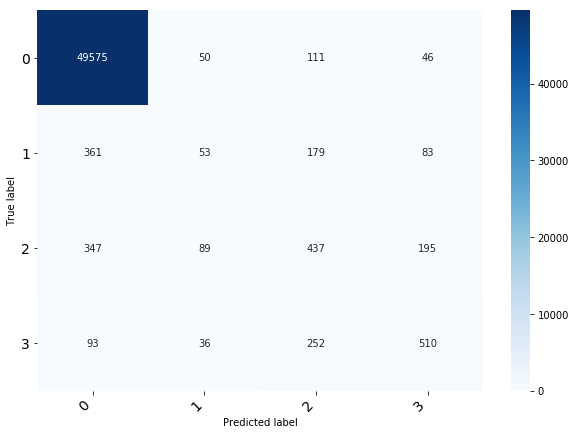

In [0]:
print_confusion_matrix(cm_nl[0], np.unique(cm_nl[1]))

In [0]:
reg_em, prec_score_em, rec_score_em, f_score_em, cm, y_pred_em = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, step_20_mins, model_path, **hyperparams)



              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49780
           1       0.25      0.07      0.11       676
           2       0.44      0.39      0.41      1068
           3       0.61      0.59      0.60       891

    accuracy                           0.96     52415
   macro avg       0.57      0.51      0.53     52415
weighted avg       0.96      0.96      0.96     52415

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564138141.1756096.dat


In [0]:
cm

(array([[49562,    38,   120,    60],
        [  390,    45,   171,    70],
        [  383,    66,   416,   203],
        [  101,    29,   235,   526]]), array([0, 0, 0, ..., 0, 0, 0]))

In [0]:
prec_score, rec_score, f_score

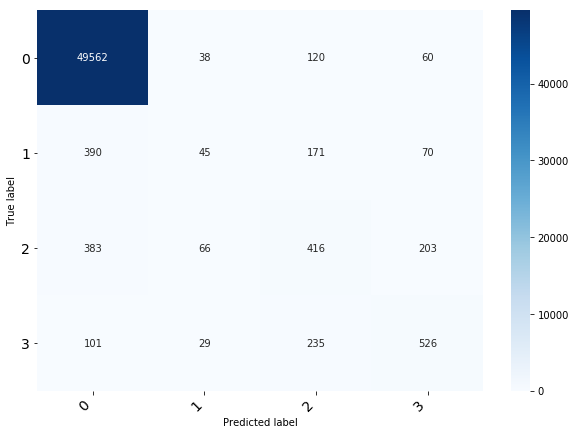

In [0]:
print_confusion_matrix(cm[0], np.unique(cm[1]))

Drop month and hour from feature list for verification of relevance

In [0]:
feats_klo_red = ['KLO_Wind_dir', 'KLO_Wind_speed', 'KLO_Wind_max', 'KLO_QFF', 'KLO_QNH', 'KLO_QFE', 'KLO_Air_temp', 'KLO_Hum']
df_train_x = df_train_klo[feats_klo_red]
df_train_y = df_train_klo[target_col]
df_test_x = df_test_klo[feats_klo_red]
df_test_y = df_test_klo[target_col]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_red, prec_score_nl_red, rec_score_nl_red, f_score_nl_red, cm_nl_red = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49782
           1       0.23      0.06      0.10       676
           2       0.45      0.42      0.43      1068
           3       0.63      0.60      0.61       891

    accuracy                           0.97     52417
   macro avg       0.57      0.52      0.53     52417
weighted avg       0.96      0.97      0.96     52417

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564147866.6347737.dat

 Time taken: 0 hours 0 minutes and 3.11 seconds.


In [0]:
all_klo_features = [c for c in df_base_train.columns if re.search('KLO', c)]

In [0]:
df_train_x = df_base_train[all_klo_features] 
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[all_klo_features] 
df_test_y = df_base_test[target_col]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext, prec_score_nl_ext, rec_score_nl_ext, f_score_nl_ext, cm_nl_ext = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_extl, prec_score_nl_extl, rec_score_nl_extl, f_score_nl_extl, cm_nl_extl = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, model_path, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     49782
           1       0.33      0.11      0.17       676
           2       0.48      0.48      0.48      1068
           3       0.68      0.67      0.68       891

    accuracy                           0.97     52417
   macro avg       0.62      0.56      0.58     52417
weighted avg       0.96      0.97      0.97     52417

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564151005.1457632.dat

 Time taken: 0 hours 0 minutes and 12.12 seconds.
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49780
           1       0.26      0.08      0.12       676
           2       0.47      0.40      0.43      1068
           3       0.66      0.66      0.66       891

    accuracy                           0.97     52415
   macro avg       0.59      0.53      0.55     52415
weighted avg       0.96   

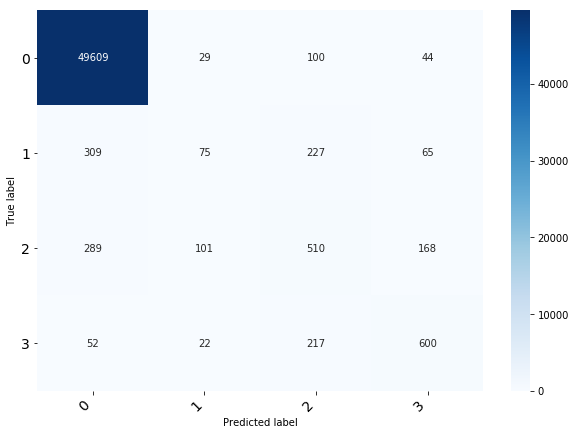

In [0]:
print_confusion_matrix(cm_nl_ext[0], np.unique(cm_nl_ext[1]))

In [0]:
all_klo_features

['KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QFE',
 'KLO_QFF',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'QNH_BIZ_minus_KLO',
 'QNH_BIZ_minus_KLO_1',
 'QNH_BIZ_minus_KLO_2',
 'QNH_BUS_minus_KLO',
 'QNH_BUS_minus_KLO_1',
 'QNH_BUS_minus_KLO_2',
 'QNH_GUT_minus_KLO',
 'QNH_GUT_minus_KLO_1',
 'QNH_GUT_minus_KLO_2',
 'QNH_KLO_minus_KOP',
 'QNH_KLO_minus_KOP_1',
 'QNH_KLO_minus_KOP_2',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MOA_1',
 'QNH_KLO_minus_MOA_2',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_MUB_1',
 'QNH_KLO_minus_MUB_2',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PAY_1',
 'QNH_KLO_minus_PAY_2',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_PUY_1',
 'QNH_KLO_minus_PUY_2',
 'QNH_KLO_minus_REH',
 'QNH_KLO_minus_REH_1',
 'QNH_KLO_minus_REH_2',
 'QNH_KLO_minus_SHA',
 'QNH_KLO_min

In [0]:
all_klo_features_minus_press_lag = [c for c in all_klo_features if not(re.search('^QNH.*\d$', c))]
all_klo_features_minus_press_lag

['KLO_Air_temp',
 'KLO_Hum',
 'KLO_Hum_delta_3',
 'KLO_Hum_delta_6',
 'KLO_QFE',
 'KLO_QFF',
 'KLO_QNH',
 'KLO_Wind_dir',
 'KLO_Wind_dir_delta',
 'KLO_Wind_dir_delta-3',
 'KLO_Wind_dir_delta-6',
 'KLO_Wind_max',
 'KLO_Wind_max_delta_3',
 'KLO_Wind_max_delta_6',
 'KLO_Wind_speed',
 'KLO_Wind_speed_delta_3',
 'KLO_Wind_speed_delta_6',
 'QNH_BIZ_minus_KLO',
 'QNH_BUS_minus_KLO',
 'QNH_GUT_minus_KLO',
 'QNH_KLO_minus_KOP',
 'QNH_KLO_minus_MOA',
 'QNH_KLO_minus_MUB',
 'QNH_KLO_minus_PAY',
 'QNH_KLO_minus_PUY',
 'QNH_KLO_minus_REH',
 'QNH_KLO_minus_SHA',
 'QNH_KLO_minus_SMA',
 'QNH_KLO_minus_TAE',
 'QNH_KLO_minus_VAD',
 'QNH_KLO_minus_WAE',
 'QNH_KLO_minus_WYN']

In [0]:
df_train_x = df_base_train[all_klo_features_minus_press_lag] 
df_train_y = df_base_train[target_col]
df_test_x = df_base_test[all_klo_features_minus_press_lag] 
df_test_y = df_base_test[target_col]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext3, prec_score_nl_ext3, rec_score_nl_ext3, f_score_nl_ext3, cm_nl_ext3 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_extl3, prec_score_nl_extl3, rec_score_nl_extl3, f_score_nl_extl3, cm_nl_extl3 = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, model_path, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     49782
           1       0.33      0.11      0.17       676
           2       0.50      0.50      0.50      1068
           3       0.70      0.68      0.69       891

    accuracy                           0.97     52417
   macro avg       0.63      0.57      0.59     52417
weighted avg       0.96      0.97      0.97     52417

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564156997.5632617.dat

 Time taken: 0 hours 0 minutes and 8.39 seconds.
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     49780
           1       0.29      0.07      0.11       676
           2       0.48      0.44      0.46      1068
           3       0.68      0.67      0.68       891

    accuracy                           0.97     52415
   macro avg       0.61      0.55      0.56     52415
weighted avg       0.96    

<h3>Run some tests before dropping the lagged diferences of pressure differences</h3>

In [0]:
feats_to_drop = [c for c in df_master.columns if re.search('^QNH_.*\d$', c)]

In [0]:
# 	manual_duration_class	rule4_episode_1_0	rule4_duration_class
target_col_1 = 'manual_bise'

df_train_x = df_base_train[all_klo_features_minus_press_lag] 
df_train_y = df_base_train[target_col_1]
df_test_x = df_base_test[all_klo_features_minus_press_lag] 
df_test_y = df_base_test[target_col_1]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext2, prec_score_nl_ext2, rec_score_nl_ext2, f_score_nl_ext2, cm_nl_ext2 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, None, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_extl2, prec_score_nl_extl2, rec_score_nl_extl2, f_score_nl_extl2, cm_nl_extl2 = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, None, **hyperparams)

timer(start)


              precision    recall  f1-score   support

           0       0.97      0.98      0.97     45127
           1       0.87      0.81      0.84      7290

    accuracy                           0.96     52417
   macro avg       0.92      0.89      0.91     52417
weighted avg       0.96      0.96      0.96     52417


 Time taken: 0 hours 0 minutes and 7.85 seconds.
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45125
           1       0.86      0.78      0.82      7290

    accuracy                           0.95     52415
   macro avg       0.91      0.88      0.90     52415
weighted avg       0.95      0.95      0.95     52415


 Time taken: 0 hours 0 minutes and 7.85 seconds.


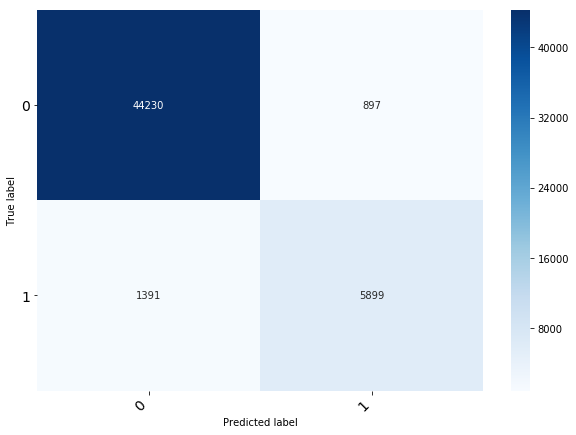

In [0]:
print_confusion_matrix(cm_nl_ext2[0], np.unique(cm_nl_ext2[1]))

In [0]:
df_train_x = df_base_train[all_klo_features] 
df_train_y = df_base_train[target_col_1]
df_test_x = df_base_test[all_klo_features] 
df_test_y = df_base_test[target_col_1]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext, prec_score_nl_ext, rec_score_nl_ext, f_score_nl_ext, cm_nl_ext = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, None, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_extl, prec_score_nl_extl, rec_score_nl_extl, f_score_nl_extl, cm_nl_extl = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, None, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     45127
           1       0.87      0.81      0.84      7290

    accuracy                           0.96     52417
   macro avg       0.92      0.89      0.91     52417
weighted avg       0.96      0.96      0.96     52417


 Time taken: 0 hours 0 minutes and 10.86 seconds.
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     45125
           1       0.86      0.78      0.82      7290

    accuracy                           0.95     52415
   macro avg       0.91      0.88      0.90     52415
weighted avg       0.95      0.95      0.95     52415


 Time taken: 0 hours 0 minutes and 10.94 seconds.


In [0]:
# 	manual_duration_class	rule4_episode_1_0	rule4_duration_class
target_col_1 = 'manual_duration_class'

df_train_x = df_base_train[all_klo_features_minus_press_lag] 
df_train_y = df_base_train[target_col_1]
df_test_x = df_base_test[all_klo_features_minus_press_lag] 
df_test_y = df_base_test[target_col_1]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext4, prec_score_nl_ext4, rec_score_nl_ext4, f_score_nl_ext4, cm_nl_ext4 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_extl4, prec_score_nl_extl4, rec_score_nl_extl4, f_score_nl_extl4, cm_nl_extl4 = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, model_path, **hyperparams)

timer(start)


df_train_x = df_base_train[all_klo_features] 
df_train_y = df_base_train[target_col_1]
df_test_x = df_base_test[all_klo_features] 
df_test_y = df_base_test[target_col_1]

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext5, prec_score_nl_ext5, rec_score_nl_ext5, f_score_nl_ext5, cm_nl_ext5 = run_xgboost_prediction_no_lag(df_train_x, df_train_y, df_test_x, df_test_y, model_path, **hyperparams)

timer(start)

start = timer()

# never give a variable the same name as a module (e.g. confusion_matrix)
reg_nl_ext5, prec_score_nl_ext5, rec_score_nl_ext5, f_score_nl_ext5, cm_nl_ext5 = run_xgboost_prediction(df_train_x, df_train_y, df_test_x, df_test_y, steps_20_mins, model_path, **hyperparams)

timer(start)

              precision    recall  f1-score   support

           0       0.96      0.99      0.97     45127
           1       0.40      0.22      0.29      1695
           2       0.47      0.55      0.51      2512
           3       0.67      0.45      0.54      3083

    accuracy                           0.91     52417
   macro avg       0.63      0.55      0.58     52417
weighted avg       0.90      0.91      0.90     52417

saving to ../gdrive/My Drive/Colab Notebooks/serializations/xgb_no_tuning_single_pred1564157231.3247945.dat

 Time taken: 0 hours 0 minutes and 8.95 seconds.
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     45125
           1       0.41      0.20      0.27      1695
           2       0.48      0.53      0.50      2512
           3       0.68      0.45      0.54      3083

    accuracy                           0.91     52415
   macro avg       0.63      0.54      0.57     52415
weighted avg       0.90    

In [0]:
hyperparams1 = {'subsample': 0.4, 'scale_pos_weight': 1, 'n_estimators': 50, 
               'max_depth': 5, 'learning_rate': 0.1, 'gamma': 1, 'colsample_bytree': 1,
                'num_class': 2, 'gpu_id': 0, 'tree_method': "gpu_hist", 'eval_metric': 'mlogloss'}

In [0]:
target_col

'rule4_duration_class'

In [0]:
print(df_train_all_feats.shape, df_test_all_feats.shape)

(210384, 63) (210384, 63)


<h2>All stations</h2>

In [0]:
eatures = ['month', 'hour', 'KLO_Wind_dir', 'KLO_Wind_speed', 'KLO_Wind_max', 'KLO_QFF', 'KLO_QNH', 'KLO_QFE', 'KLO_Air_temp', 
            'KLO_Hum', 'REH_Wind_dir', 'REH_Wind_speed', 'REH_Wind_max', 'REH_QFF', 'REH_QNH', 'REH_QFE', 'REH_Air_temp', 
            'REH_Hum', 'SMA_Wind_dir', 'SMA_Wind_speed', 'SMA_Wind_max', 'SMA_QFF', 'SMA_QNH', 'SMA_QFE', 'SMA_Air_temp', 
            'SMA_Hum', 'TAE_Wind_dir', 'TAE_Wind_speed', 'TAE_Wind_max', 'TAE_QFF', 'TAE_QNH', 'TAE_QFE', 'TAE_Air_temp', 
            'TAE_Hum', 'WAE_Wind_dir', 'WAE_Wind_speed', 'WAE_Wind_max', 'WAE_QFF', 'WAE_QNH', 'WAE_QFE', 'WAE_Air_temp', 
            'WAE_Hum', 'BIZ_Wind_dir', 'BIZ_Wind_speed', 'BIZ_Wind_max', 'BIZ_QFF', 'BIZ_QNH', 'BIZ_QFE', 'BIZ_Air_temp', 
            'BIZ_Hum', 'BUS_Wind_dir', 'BUS_Wind_speed', 'BUS_Wind_max', 'BUS_QFF', 'BUS_QNH', 'BUS_QFE', 'BUS_Air_temp', 
            'BUS_Hum', 'GUT_Wind_dir', 'GUT_Wind_speed', 'GUT_Wind_max', 'GUT_QFF', 'GUT_QNH', 'GUT_QFE', 'GUT_Air_temp', 
            'GUT_Hum', 'KOP_Wind_dir', 'KOP_Wind_speed', 'KOP_Wind_max', 'KOP_QFF', 'KOP_QNH', 'KOP_QFE', 'KOP_Air_temp', 
            'KOP_Hum', 'MOA_Wind_dir', 'MOA_Wind_speed', 'MOA_Wind_max', 'MOA_QFF', 'MOA_QNH', 'MOA_QFE', 'MOA_Air_temp', 
            'MOA_Hum', 'MUB_Wind_dir', 'MUB_Wind_speed', 'MUB_Wind_max', 'MUB_QFF', 'MUB_QNH', 'MUB_QFE', 'MUB_Air_temp', 
            'MUB_Hum', 'PAY_Wind_dir', 'PAY_Wind_speed', 'PAY_Wind_max', 'PAY_QFF', 'PAY_QNH', 'PAY_QFE', 'PAY_Air_temp', 
            'PAY_Hum', 'PUY_Wind_dir', 'PUY_Wind_speed', 'PUY_Wind_max', 'PUY_QFF', 'PUY_QNH', 'PUY_QFE', 'PUY_Air_temp', 
            'PUY_Hum', 'SHA_Wind_dir', 'SHA_Wind_speed', 'SHA_Wind_max', 'SHA_QFF', 'SHA_QNH', 'SHA_QFE', 'SHA_Air_temp', 
            'SHA_Hum', 'VAD_Wind_dir', 'VAD_Wind_speed', 'VAD_Wind_max', 'VAD_QFF', 'VAD_QNH', 'VAD_QFE', 'VAD_Air_temp', 
            'VAD_Hum', 'WYN_Wind_dir', 'WYN_Wind_speed', 'WYN_Wind_max', 'WYN_QFF', 'WYN_QNH', 'WYN_QFE', 'WYN_Air_temp', 
            'WYN_Hum']